# Quantile Regression

 Quantile regression seeks to extend these ideas to the estimation of conditional quantile functions—models in which quantiles of the conditional distribution of the response variable are expressed as functions of observed covariates.

In [356]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

## Create Dataset

One of the key assumptions of OLS is *heteroskedacicity*, the varience dosent change across x. In many cases this is not true, liek education on salary. For this the varience goes up as eduaction goes up.

TODO:
Typically this is accounted for my transforming the data till it holds, like taking the log etc.

In [357]:
# OLS model to generate data
model = lambda x, b: b[0]*x + b[1]

In [358]:
n = 1000
datasets = []

In [359]:
data = {}

data['b'] = [2, 1.5]
data['x'] = np.random.uniform(1, 20, n)
data['y'] = model(data['x'], data['b']) + np.random.normal(0, 5, n)

datasets.append(data)

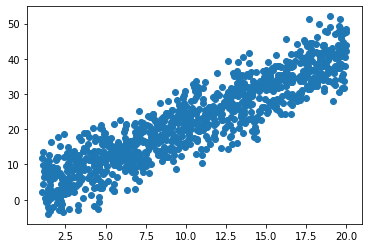

In [360]:
plt.scatter(data['x'], data['y'])
plt.show()

In [361]:
data = {}

data['b'] = [2, 1.5]
data['x'] = np.random.uniform(1, 20, n)
# the varience grows as x increases
data['y'] = model(data['x'], data['b']) + np.random.normal(np.zeros_like(data['x']), data['x']/2, len(data['x']))

datasets.append(data)

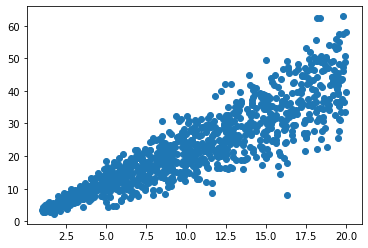

In [362]:
plt.scatter(data['x'], data['y'])
plt.show()

## OLS 

In [363]:
# loss funciton
mse = lambda b: np.sum((data['y'] - model(data['x'], b))**2)

In [364]:
# solve optimization problem
res = minimize(mse, [0,0])
ols_b_hat = res.x

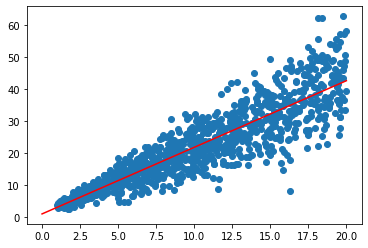

In [365]:
plt.scatter(data['x'], data['y'])
x_lin = np.linspace(0,20,1000)
plt.plot(x_lin, model(x_lin, ols_b_hat), c='r')
plt.show()

## Optimization

We can form basic statistics such as mean and median as optimiation problems.

$$ \mathbb{E}[x] = \min_{\alpha} \sum_{x}(x_i - \alpha)^2 $$


### Mean

Just like OLS done above we use the MSE of just the value

In [366]:
mean_f = lambda x: np.sum((data['y'] - x)**2)

In [367]:
res = minimize(mean_f, 0)
res

      fun: 156813.9531289473
 hess_inv: array([[0.0005]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([22.00589133])

In [368]:
res.x[0]

22.00589132790973

In [369]:
data['y'].mean()

22.00589129875318

### Median

$$ \text{median } x = \min_{\alpha} \sum_{x}\vert x_i - \alpha \vert $$


In [370]:
median_f = lambda x: np.sum(np.abs(data['y'] - x))

In [371]:
minimize(median_f, 0).x[0]

20.365359651742626

In [372]:
np.quantile(data['y'], .5)

20.38677855984956

###  Quartiles

$$ \text{quartile}_{\tau} x = \min_{\alpha} \sum_{x} \rho_{\tau}(x_i - \alpha)$$
$$ \rho_\tau = \tau\max(r, 0) + (1-\tau)\max(-r,0) $$

In [373]:
check_loss = np.vectorize(lambda tau, r: tau*max(r,0) + (1-tau)*max(-r,0))

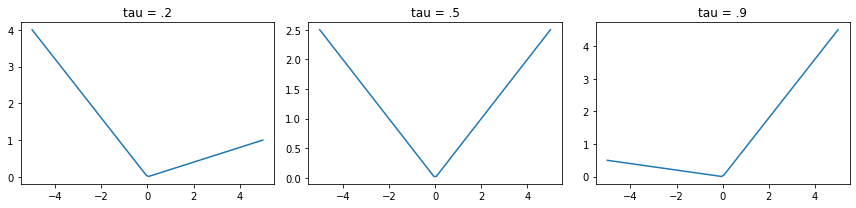

In [374]:
lin = np.linspace(-5,5,100)
fig, axs = plt.subplots(ncols=3, figsize=(12,3))

axs[0].plot(lin, check_loss(.2, lin))
axs[1].plot(lin, check_loss(.5, lin))
axs[2].plot(lin, check_loss(.9, lin))
axs[0].set_title('tau = .2')
axs[1].set_title('tau = .5')
axs[2].set_title('tau = .9')

plt.tight_layout()
plt.show()

In [375]:
tau = .3
quartile_f = lambda alpha: np.sum(check_loss(tau, (data['y'] - alpha)))

In [376]:
np.quantile(data['y'], tau)

13.579526930351538

In [377]:
minimize(quartile_f, 0).x[0]

13.570359206884797

## Quartile Regression

In [378]:
# loss funciton
def quartile_loss(tau):
    return lambda b: np.sum(check_loss(tau, (data['y'] - model(data['x'], b))))

In [379]:
# solve optimization problem
res = minimize(quartile_loss(.1), [0,0])
b_hat = res.x

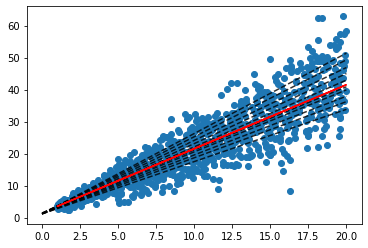

In [380]:
data = datasets[1]
plt.scatter(data['x'], data['y'])
for tau in np.linspace(.2,.8,10):
    
    # solve optimization problem
    res = minimize(quartile_loss(tau), [0,0])
    b_hat = res.x
    
    plt.plot(x_lin, model(x_lin, b_hat), c='black', alpha=.8, ls='--')
plt.plot(data['x'], model(data['x'], data['b']), c='r')
plt.show()

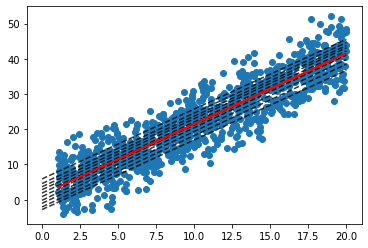

In [381]:
data = datasets[0]
plt.scatter(data['x'], data['y'])
for tau in np.linspace(.2,.8,10):
    
    # solve optimization problem
    res = minimize(quartile_loss(tau), [0,0])
    b_hat = res.x
    
    plt.plot(x_lin, model(x_lin, b_hat), c='black', alpha=.8, ls='--')
plt.plot(data['x'], model(data['x'], data['b']), c='r')
plt.show()

### Compare $\beta$

In [335]:
data = datasets[1]
quartile_bs = []
for tau in np.linspace(.01,.99,100):
    # solve optimization problem
    res = minimize(quartile_loss(tau), [0,0])
    b_hat = res.x
    quartile_bs.append([tau, b_hat[0]])
quartile_bs = np.array(quartile_bs)

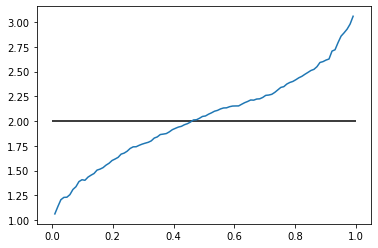

In [336]:
plt.hlines(data['b'][0],0,1)
plt.plot(quartile_bs[:,0], quartile_bs[:,1])
plt.show()

## Statsmodels

In [338]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [352]:
y, X = data['y'], sm.add_constant(data['x'])
model = sm.QuantReg(y, X)
res = model.fit(q=.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      y   Pseudo R-squared:               0.6146
Model:                       QuantReg   Bandwidth:                       1.965
Method:                 Least Squares   Sparsity:                        9.204
Date:                Sat, 12 Sep 2020   No. Observations:                 1000
Time:                        02:45:35   Df Residuals:                      998
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1940      0.310      3.848      0.000       0.585       1.803
x1             2.0492      0.027     76.755      0.000       1.997       2.102
==============================================================================
"""